In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# You can configure the format of the images: ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’.
%config InlineBackend.figure_format = 'svg'
# this statement allows the visuals to render within your Jupyter Notebook
%matplotlib inline


In [2]:
df = pd.read_csv('./vgsales.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


In [3]:
#Cleaning Data
#chick the missing values
df.isna().sum()
#replac missing values of the years by 0
df.Year.fillna(value=0 , inplace=True)
#drop the rows with missing values of publisher
df.dropna(subset=['Publisher'], inplace=True)
df.isna().sum()

#removing Whitespace
columns = [1, 2, 4, 5]
result = map(lambda x: df.x.str.strip(), columns)

#changing the type of Year column from float to int
df['Year'] = df.Year.astype('int64')
df.dtypes

#sort according to years
df.sort_values('Year', ascending=True, inplace=True)

#chick for duplicate rows
print(df.drop_duplicates().size, df.size)
#the size is the same SO no duplicates rows


181940 181940


<AxesSubplot:xlabel='Year', ylabel='Global_Sales'>

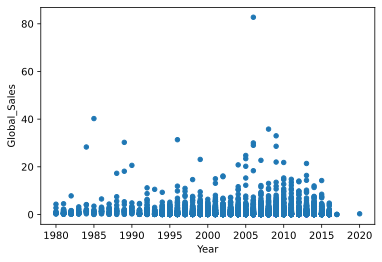

In [4]:

#chick for outlier values
#create Scatter Plot
df_EDA = df[df.Year != 0]
df_EDA.plot.scatter(x='Year', y='Global_Sales')



<AxesSubplot:xlabel='Year', ylabel='Global_Sales'>

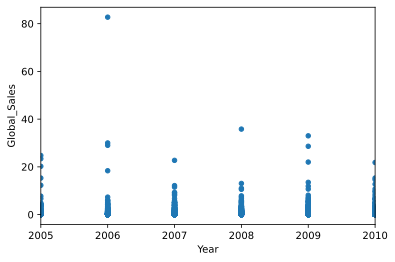

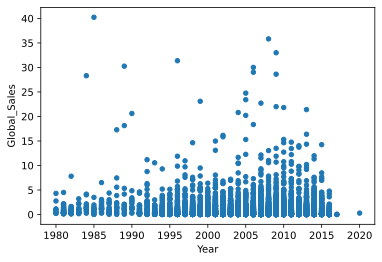

In [5]:
#scale to determine the specific "Year" of the outlier value on Global Sales
df_EDA.plot.scatter(x='Year', y='Global_Sales', xlim=(2005, 2010))

#from the scatter plot we determinte the outlier value is in the year 2006
#delet outlier
df = df[df.Global_Sales != 82.74]
df_EDA = df_EDA[df_EDA.Global_Sales != 82.74]
df_EDA.plot.scatter(x='Year', y='Global_Sales')

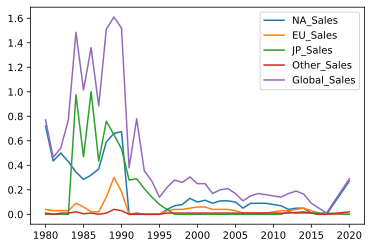

In [6]:
#EDA

#average sale through the years
df_year_median = df_EDA.groupby('Year')[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']].median().reset_index()
for column in df_year_median.iloc[:, [1, 2, 3, 4, 5]]:
    plt.plot(df_year_median['Year'], df_year_median[column],)
    plt.legend(list(map(lambda column: column, df_year_median.iloc[:, [1, 2, 3, 4, 5]])))


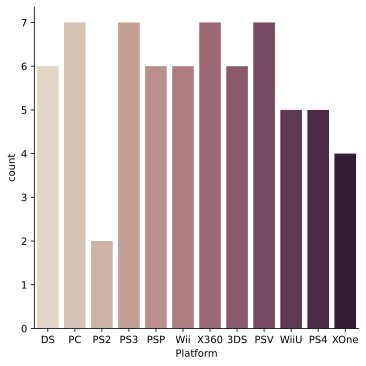

In [7]:
#popular platforms last 10 years 
df_Platform_median = df_EDA.groupby(['Year', 'Platform'])[['Global_Sales']].median().reset_index()
df_Platform_median
df_Platform_median = df_Platform_median[df_Platform_median.Year >= 2010]

sns.catplot(data=df_Platform_median, x="Platform", kind="count", palette="ch:.25")# hue="Platform", multiple="stack"

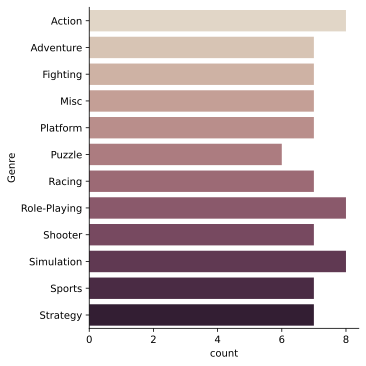

In [8]:
#popular genres last 10 years 
df_Genre_median = df_EDA.groupby(['Year', 'Genre'])[['Global_Sales']].median().reset_index()
df_Genre_median = df_Genre_median[df_Genre_median.Year >= 2010]
#df_Genre_median.info()
sns.catplot(data=df_Genre_median, y="Genre", kind="count", palette="ch:.25")

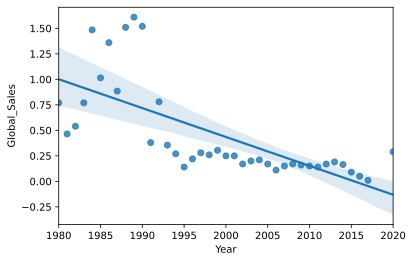

In [9]:
df_year_mean = df_EDA.groupby('Year')[['Global_Sales']].median().reset_index()
sns.regplot(x="Year", y="Global_Sales", data=df_year_mean);

In [10]:
#Training
#create a copy of the database for training
games = df.select_dtypes(exclude=['object']).copy()

#create a database with dummy variables for 'Platform' and 'Genre'
games['Platform']=df['Platform']
games['Genre']=df['Genre']
games = pd.get_dummies(games)
games.info()
games.size

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16539 entries, 9171 to 5957
Data columns (total 50 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rank                16539 non-null  int64  
 1   Year                16539 non-null  int64  
 2   NA_Sales            16539 non-null  float64
 3   EU_Sales            16539 non-null  float64
 4   JP_Sales            16539 non-null  float64
 5   Other_Sales         16539 non-null  float64
 6   Global_Sales        16539 non-null  float64
 7   Platform_2600       16539 non-null  uint8  
 8   Platform_3DO        16539 non-null  uint8  
 9   Platform_3DS        16539 non-null  uint8  
 10  Platform_DC         16539 non-null  uint8  
 11  Platform_DS         16539 non-null  uint8  
 12  Platform_GB         16539 non-null  uint8  
 13  Platform_GBA        16539 non-null  uint8  
 14  Platform_GC         16539 non-null  uint8  
 15  Platform_GEN        16539 non-null  uint8  
 16  Pl

826950

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
import xgboost as xgb

In [19]:
#get just the years above 2000
games_2000_to_2020 = games[games.Year >= 2000]

#X just the dummy variables for 'Platform' and 'Genre'
X, y = games_2000_to_2020.iloc[:, lambda games_2000_to_2020: list(range(7, 50))], games_2000_to_2020.iloc[:, 6]

#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [20]:
#Evaluate models with Root Mean Squared Error
def rmse(actuals, preds):
    return np.sqrt(((actuals - preds) ** 2).mean())

In [21]:
#xgboost
#Linear regression benchmark
lr = LinearRegression()
lr.fit(X_train, y_train)
rmse(lr.predict(X_test), y_test)

1.2603364999401225

In [22]:
#Random forest benchmark
rf = RandomForestRegressor(n_estimators = 100, max_features = 3, n_jobs=-1)
rf.fit(X_train,y_train)
rmse(rf.predict(X_test), y_test)

1.2557671576069398

In [23]:
#xgboost
gbm = xgb.XGBRegressor( 
                       n_estimators=30000, #arbitrary large number
                       max_depth=3,
                       objective="reg:squarederror",  # Other options: https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters
                       learning_rate=.1, 
                       subsample=1,
                       min_child_weight=1,
                       colsample_bytree=.8
                      )

eval_set=[(X_train,y_train),(X_val,y_val)] #tracking train/validation error as we go
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='rmse',
                    early_stopping_rounds=20,
                    verbose=True #gives output log as below
                   )

[0]	validation_0-rmse:1.33824	validation_1-rmse:1.20945
[1]	validation_0-rmse:1.33652	validation_1-rmse:1.20819
[2]	validation_0-rmse:1.33476	validation_1-rmse:1.20708
[3]	validation_0-rmse:1.33333	validation_1-rmse:1.20552
[4]	validation_0-rmse:1.33230	validation_1-rmse:1.20453
[5]	validation_0-rmse:1.33112	validation_1-rmse:1.20407
[6]	validation_0-rmse:1.32986	validation_1-rmse:1.20243
[7]	validation_0-rmse:1.32886	validation_1-rmse:1.20208
[8]	validation_0-rmse:1.32766	validation_1-rmse:1.20110
[9]	validation_0-rmse:1.32688	validation_1-rmse:1.20030
[10]	validation_0-rmse:1.32607	validation_1-rmse:1.19991
[11]	validation_0-rmse:1.32546	validation_1-rmse:1.19916
[12]	validation_0-rmse:1.32479	validation_1-rmse:1.19882
[13]	validation_0-rmse:1.32429	validation_1-rmse:1.19844
[14]	validation_0-rmse:1.32382	validation_1-rmse:1.19788
[15]	validation_0-rmse:1.32337	validation_1-rmse:1.19760
[16]	validation_0-rmse:1.32247	validation_1-rmse:1.19667
[17]	validation_0-rmse:1.32185	validation

In [24]:
# predict using n_estimators with lowest validation error
#test data
rmse(gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit),y_test) 

C:\Users\vpli-\anaconda3\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


1.257485596422216

In [25]:
#val data
rmse(gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit),y_val)

1.1879598547166985

In [66]:
xdf = pd.DataFrame(X_val[:1])
ydf = pd.DataFrame(y_val[:1])
#df.shape
#X_val[:1]
#.iloc[0, :]
#xdf.shape
print(X_val.shape , xdf.shape, ydf.shape)
ydf

(2863, 43) (1, 43) (1, 1)


Global_Sales
6174          0.28

In [67]:
gbm.predict(xdf, ntree_limit=gbm.best_ntree_limit)
#rmse(gbm.predict(xdf, ntree_limit=gbm.best_ntree_limit),ydf)

C:\Users\vpli-\anaconda3\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


array([0.46990222], dtype=float32)